In [1]:
!pip install -q efficientnet


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import math, re, os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import efficientnet.tfkeras as efn
import tensorflow.keras.layers as L
from tensorflow.keras.applications.resnet50 import ResNet50

from sklearn import metrics
from sklearn.model_selection import train_test_split
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

D1022 16:32:19.555315896      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1022 16:32:19.555342489      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1022 16:32:19.555346240      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1022 16:32:19.555348916      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1022 16:32:19.555351187      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1022 16:32:19.555353794      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1022 16:32:19.555356378      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1022 16:32:19.

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [4]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 10
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/alaska2-image-steganalysis


In [5]:
def append_path(pre):
    return np.vectorize(lambda file: os.path.join(GCS_DS_PATH, pre, file))

In [6]:
sub = pd.read_csv('/kaggle/input/alaska2-image-steganalysis/sample_submission.csv')
train_filenames = np.array(os.listdir("/kaggle/input/alaska2-image-steganalysis/Cover/"))

In [7]:
np.random.seed(0)
positives = train_filenames.copy()
negatives = train_filenames.copy()
np.random.shuffle(positives)
np.random.shuffle(negatives)
parti = 3000
jmipod = append_path('JMiPOD')(positives[:parti])
juniward = append_path('JUNIWARD')(positives[parti:parti*2])
uerd = append_path('UERD')(positives[parti*2:parti*3])

pos_paths = np.concatenate([jmipod, juniward, uerd])

In [8]:
test_paths = append_path('Test')(sub.Id.values)
neg_paths = append_path('Cover')(negatives[:parti*3])

In [9]:
train_paths = np.concatenate([pos_paths, neg_paths])
train_labels = np.array([1] * len(pos_paths) + [0] * len(neg_paths))

In [10]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train_paths, train_labels, test_size=0.1, random_state=2020)

In [14]:
print(len(train_paths))

16200


In [11]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [12]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [13]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [15]:
scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    min_lr=0.0000001
)

In [16]:
# def select_model(name):
#     if name == 'EfficientNet3' :
#             base_model = efn.EfficientNetB3(input_shape=(512, 512, 3),
#                                             weights='imagenet',
#                                             include_top = False,
#                                            )    
#     elif name == 'ResNet' :
#             base_model = ResNet50(weights = 'imagenet',include_top=False,input_shape=(512, 512, 3))
#     return base_model

In [31]:
with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB3(
            input_shape=(512, 512, 3),
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1, activation='sigmoid')
    ])
        
    opt = tf.optimizers.Adam(learning_rate=0.0000001)
    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 16, 16, 1536)     10783528  
 )                                                               
                                                                 
 global_average_pooling2d_5   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 1)                 1537      
                                                                 
Total params: 10,785,065
Trainable params: 10,697,769
Non-trainable params: 87,296
_________________________________________________________________


In [32]:

STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

history = model.fit(
    train_dataset, 
    epochs=5, 
    callbacks=[early, scheduler],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset
)


Epoch 1/5


2023-10-22 17:26:47.265853: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-22 17:26:48.557675: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


126/126 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.5248

2023-10-22 17:30:36.297034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-22 17:30:36.618240: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


126/126 [==============================] - 317s 1s/step - loss: 0.6943 - accuracy: 0.5248 - val_loss: 0.7197 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/5
126/126 [==============================] - 88s 701ms/step - loss: 0.6678 - accuracy: 0.5569 - val_loss: 0.6665 - val_accuracy: 0.5628 - lr: 0.0010
Epoch 3/5
126/126 [==============================] - 90s 712ms/step - loss: 0.6586 - accuracy: 0.5723 - val_loss: 0.6650 - val_accuracy: 0.5756 - lr: 0.0010
Epoch 4/5
126/126 [==============================] - 89s 706ms/step - loss: 0.6457 - accuracy: 0.5954 - val_loss: 0.6886 - val_accuracy: 0.5606 - lr: 0.0010
Epoch 5/5
126/126 [==============================] - ETA: 0s - loss: 0.6379 - accuracy: 0.6076
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
126/126 [==============================] - 89s 708ms/step - loss: 0.6379 - accuracy: 0.6076 - val_loss: 0.6899 - val_accuracy: 0.5917 - lr: 0.0010


In [ ]:
def display_curves(training, validation, title, subplot):
    """
    Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
    """
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['Efficient', 'ResNet'])

/tmp/ipykernel_15/2441444733.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


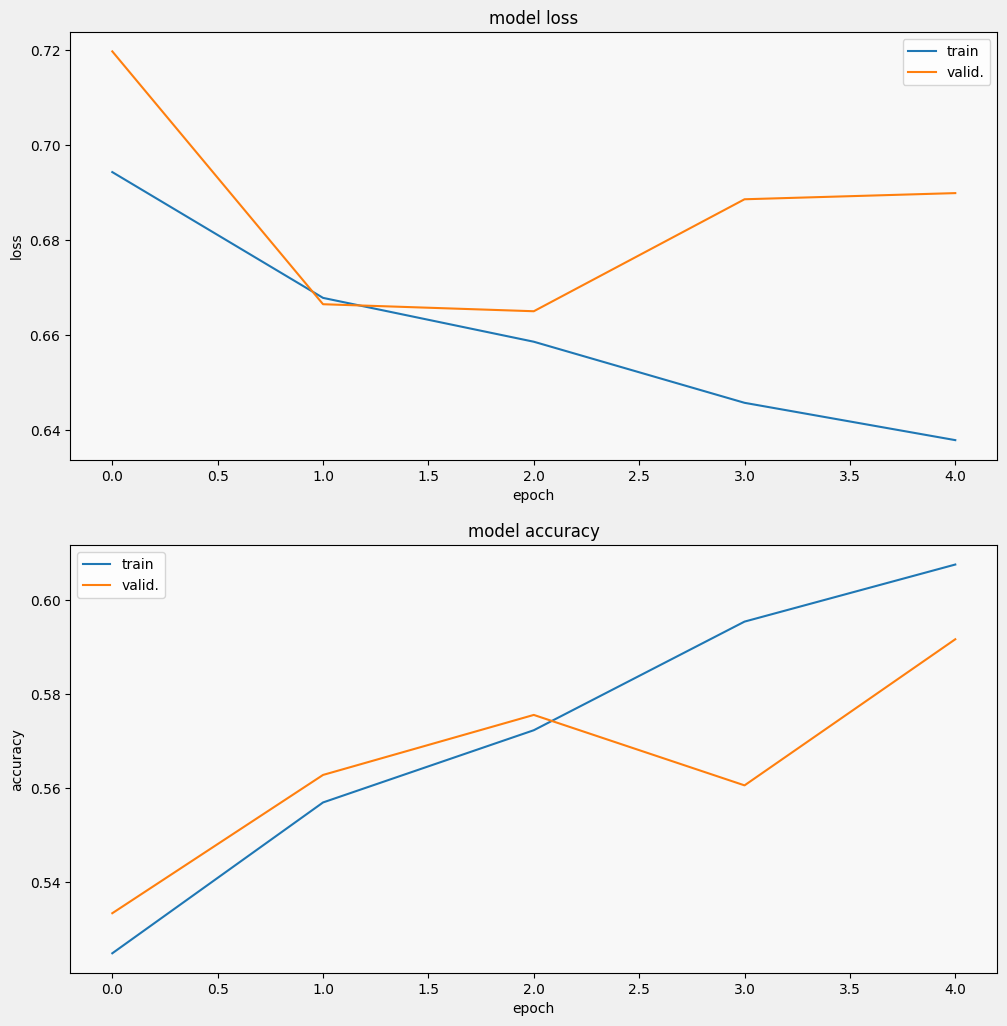

In [33]:
display_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)
display_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy', 212)

In [34]:
def alaska_weighted_auc(y_true, y_valid):
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights = [2, 1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_valid, pos_label=1)
    
    # Size of subsets
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])
    
    # The total area is normalized by the sum of weights such that the final weighted AUC is between 0 and 1.
    normalization = np.dot(areas, weights)
    
    competition_metric = 0
    for idx, weight in enumerate(weights):
        y_min = tpr_thresholds[idx]
        y_max = tpr_thresholds[idx + 1]
        mask = (y_min < tpr) & (tpr < y_max)

        x_padding = np.linspace(fpr[mask][-1], 1, 100)

        x = np.concatenate([fpr[mask], x_padding])
        y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
        # Normalize such that curve starts at y = 0
        y = y - y_min 
        score = metrics.auc(x, y)
        submetric = score * weight
        best_subscore = (y_max - y_min) * weight
        competition_metric += submetric
        
    return competition_metric / normalization

In [ ]:
model.save("/kaggle/working/model3.h5")

In [24]:
def display_training_curves(training, validation, title, subplot):
    """
    Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
    """
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy', 212)

In [35]:
y_pred=model.predict(valid_dataset)

2023-10-22 17:37:51.031440: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-22 17:37:51.347417: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


15/15 [==============================] - 55s 2s/step


In [36]:
print(alaska_weighted_auc(valid_labels, y_pred))

0.6978817170588676


In [ ]:
jmipod2 = append_path('JMiPOD')(positives[10000:20000])
juniward2 = append_path('JUNIWARD')(positives[20000:30000])
uerd2 = append_path('UERD')(positives[30000:40000])

positives2 = train_filenames.copy()
negatives2 = train_filenames.copy()
np.random.shuffle(positives2)
np.random.shuffle(negatives2)
pos_paths2 = np.concatenate([jmipod2, juniward2, uerd2])

neg_paths2 = append_path('Cover')(negatives2[30000:60000])
train_paths2 = np.concatenate([pos_paths2, neg_paths2])
train_labels2 = np.array([1] * len(pos_paths2) + [0] * len(neg_paths2))
train_paths2, test_paths, train_labels2, test_labels = train_test_split(
    train_paths2, train_labels2, test_size=0.15, random_state=2020)

In [ ]:
test_dataset2 = (
    tf.data.Dataset
    .from_tensor_slices((test_paths, test_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [ ]:
y_pred=model.predict(test_dataset2)

In [ ]:
print(alaska_weighted_auc(test_labels, y_pred))